In [1]:
from matplotlib import pyplot
plt = pyplot
%matplotlib inline 

In [6]:
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import theano
from numpy import float32
import scipy
from nolearn.lasagne import BatchIterator
from lasagne.nonlinearities import softmax, sigmoid, rectify
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
import cPickle as pickle
import pandas as pd
def load(f):
    with open(f, "rb") as fa:
        return pickle.load(fa)


def float32(k):
    return np.cast['float32'](k)

class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)
        
        
class FlipBatchIterator(BatchIterator):
    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0]
        indices = np.random.choice(bs, bs / 2, replace=False)
        Xb[indices] = Xb[indices, :, :, ::-1]
        for i in range(len(Xb)):
            n = np.random.randint(4)
            Xb[i][0] = np.rot90(Xb[i][0], n)
        
        return Xb, yb
    
rotate = scipy.ndimage.interpolation.rotate
def crop(image, dimx, dimy):
    old_dimx, old_dimy = image.shape
    fromx = (old_dimx - dimx)/2
    tox = fromx + dimx
    fromy = (old_dimy - dimy)/2
    toy = fromy + dimy
    return image[fromx:tox,fromy:toy]

class BetterBatcher(BatchIterator):
    def transform(self, Xb, yb):
        Xb, yb = super(BetterBatcher, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0]
        indices = np.random.choice(bs, bs / 2, replace=False)
        Xb[indices] = Xb[indices, :, :, ::-1]
        for i in range(len(Xb)):
            n = np.random.randint(360)
            Xb[i][0] = crop(rotate(Xb[i][0], n), 65, 65)
        
        return Xb, yb

In [5]:
X = load("data/train_X_all.pickle")
y = pd.read_csv("data/training_solutions_rev1.csv") \
    .drop('GalaxyID', 1).as_matrix().astype(np.float32)

In [9]:
net3 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 65, 65),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_ds=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_ds=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_ds=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=37, output_nonlinearity=rectify,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    batch_iterator_test=FlipBatchIterator(batch_size=128),
    regression=True,
    max_epochs=100,
    verbose=1,
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    )

net3.fit(X, y)
# with open("net3.pickle", "wb") as out:
#     pickle.dump(net3, out)

  input             	(None, 1, 65, 65)   	produces    4225 outputs
  conv1             	(None, 32, 63, 63)  	produces  127008 outputs
  pool1             	(None, 32, 32, 32)  	produces   32768 outputs
  conv2             	(None, 64, 31, 31)  	produces   61504 outputs
  pool2             	(None, 64, 16, 16)  	produces   16384 outputs
  conv3             	(None, 128, 15, 15) 	produces   28800 outputs
  pool3             	(None, 128, 8, 8)   	produces    8192 outputs
  hidden4           	(None, 500)         	produces     500 outputs
  hidden5           	(None, 500)         	produces     500 outputs
  output            	(None, 37)          	produces      37 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    0.029478  |    0.027197  |     1.083877  |             |  30.9s
     2  |    0.026891  |    0.025568  |     1.051747  |             |  30.8s
     3  |    0.024798  

NeuralNet(X_tensor_type=<function tensor4 at 0x7f1ba79bf140>,
     batch_iterator_test=<__main__.FlipBatchIterator object at 0x7f1b4cdfbe50>,
     batch_iterator_train=<__main__.FlipBatchIterator object at 0x7f1b8d0f9550>,
     conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, eval_size=0.2,
     hidden4_num_units=500, hidden5_num_units=500,
     input_shape=(None, 1, 65, 65),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv3', <class..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=100, more_params={},
     objective=<class 'lasagne.objectives.Objective'>,
  

In [11]:
with open("net3.pickle", "wb") as out:
    pickle.dump(net3, out)
    
net3.max_epochs=30
net3.fit(X, y)

with open("net3.130.pickle", "wb") as out:
    pickle.dump(net3, out)


 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    0.011213  |    0.011504  |     0.974720  |             |  29.9s
     2  |    0.011488  |    0.011753  |     0.977436  |             |  29.9s
     3  |    0.011314  |    0.011750  |     0.962965  |             |  29.9s
     4  |    0.011252  |    0.011647  |     0.966098  |             |  29.9s
     5  |    0.011226  |    0.011539  |     0.972925  |             |  29.9s
     6  |    0.011189  |    0.011551  |     0.968657  |             |  29.9s
     7  |    0.011149  |    0.011478  |     0.971405  |             |  29.9s
     8  |    0.011118  |    0.011451  |     0.970908  |             |  29.9s
     9  |    0.011083  |    0.011381  |     0.973846  |             |  29.9s
    10  |    0.011071  |    0.011436  |     0.968114  |             |  29.9s
    11  |    0.011036  |    0.011397  |     0.968332  |             |  29.9s


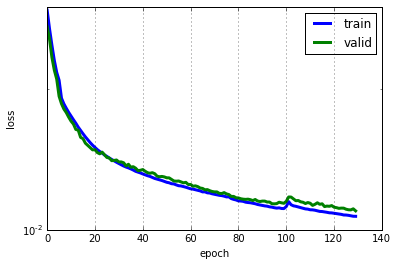

In [12]:
train_loss = np.array([i["train_loss"] for i in net3.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net3.train_history_])
plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(1e-2, 3e-2)
plt.yscale("log")
plt.show()

In [12]:
net4 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),  # !
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),  # !
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),  # !
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),  # !
        ('hidden5', layers.DenseLayer),
        
        ('dropout5', layers.DropoutLayer),  # !
        ('hidden6', layers.DenseLayer),
        
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 65, 65),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_ds=(2, 2),
    dropout1_p=0.1,  # !
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_ds=(2, 2),
    dropout2_p=0.2,  # !
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_ds=(2, 2),
    dropout3_p=0.3,  # !
    hidden4_num_units=500, 
    dropout4_p=0.5,  # !
    hidden5_num_units=500,
    
    dropout5_p=0.5,  # !
    hidden6_num_units=500,
    output_num_units=37, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),
    batch_iterator_train=FlipBatchIterator(batch_size=512),
    batch_iterator_test=FlipBatchIterator(batch_size=512),
    regression=True,
    max_epochs=200,
    verbose=1,
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    )

net4.fit(X, y)
with open("pickles/net4.pickle", "wb") as out:
    pickle.dump(net4, out)

  input             	(None, 1, 65, 65)   	produces    4225 outputs
  conv1             	(None, 32, 63, 63)  	produces  127008 outputs
  pool1             	(None, 32, 32, 32)  	produces   32768 outputs
  dropout1          	(None, 32, 32, 32)  	produces   32768 outputs
  conv2             	(None, 64, 31, 31)  	produces   61504 outputs
  pool2             	(None, 64, 16, 16)  	produces   16384 outputs
  dropout2          	(None, 64, 16, 16)  	produces   16384 outputs
  conv3             	(None, 128, 15, 15) 	produces   28800 outputs
  pool3             	(None, 128, 8, 8)   	produces    8192 outputs
  dropout3          	(None, 128, 8, 8)   	produces    8192 outputs
  hidden4           	(None, 500)         	produces     500 outputs
  dropout4          	(None, 500)         	produces     500 outputs
  hidden5           	(None, 500)         	produces     500 outputs
  dropout5          	(None, 500)         	produces     500 outputs
  hidden6           	(None, 500)         	produces     500 out

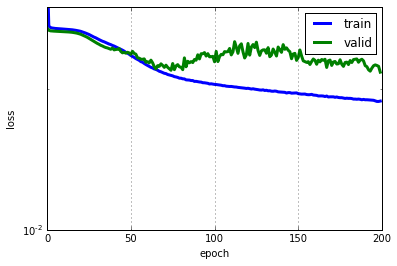

In [13]:
train_loss = np.array([i["train_loss"] for i in net4.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net4.train_history_])
plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(1e-2, 3e-2)
plt.yscale("log")
plt.show()

In [15]:
net4.max_epochs = 20
net4.fit(X, y)


 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    0.018812  |    0.022154  |     0.849113  |             |  29.0s
     2  |    0.020473  |    0.025209  |     0.812136  |             |  29.0s
     3  |    0.019222  |    0.025264  |     0.760835  |             |  29.0s
     4  |    0.019194  |    0.024649  |     0.778699  |             |  29.0s
     5  |    0.019166  |    0.026273  |     0.729505  |             |  29.0s
     6  |    0.019100  |    0.024854  |     0.768480  |             |  29.0s
     7  |    0.019058  |    0.025589  |     0.744785  |             |  29.0s
     8  |    0.019035  |    0.023149  |     0.822286  |             |  29.0s
     9  |    0.019007  |    0.025033  |     0.759279  |             |  29.0s
    10  |    0.019034  |    0.026089  |     0.729581  |             |  29.0s
    11  |    0.018973  |    0.023943  |     0.792437  |             |  29.0s


NeuralNet(X_tensor_type=<function tensor4 at 0x7f1e6ff5e1b8>,
     batch_iterator_test=<__main__.FlipBatchIterator object at 0x7f1e0f06d5d0>,
     batch_iterator_train=<__main__.FlipBatchIterator object at 0x7f1e0f06d290>,
     conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, dropout1_p=0.1,
     dropout2_p=0.2, dropout3_p=0.3, dropout4_p=0.5, dropout5_p=0.5,
     eval_size=0.2, hidden4_num_units=500, hidden5_num_units=500,
     hidden6_num_units=500, input_shape=(None, 1, 65, 65),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('dropout1', <class 'lasagne.layers.noise.DropoutLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <cla..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)

In [64]:
net5 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 65, 65),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_ds=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_ds=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_ds=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=37, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),
    batch_iterator_train=BetterBatcher(batch_size=256),
    batch_iterator_test=BetterBatcher(batch_size=256),
    regression=True,
    max_epochs=20,
    verbose=1,
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    )

net5.fit(X, y)
# with open("net5.pickle", "wb") as out:
#     pickle.dump(net5, out)

  input             	(None, 1, 65, 65)   	produces    4225 outputs
  conv1             	(None, 32, 63, 63)  	produces  127008 outputs
  pool1             	(None, 32, 32, 32)  	produces   32768 outputs
  conv2             	(None, 64, 31, 31)  	produces   61504 outputs
  pool2             	(None, 64, 16, 16)  	produces   16384 outputs
  conv3             	(None, 128, 15, 15) 	produces   28800 outputs
  pool3             	(None, 128, 8, 8)   	produces    8192 outputs
  hidden4           	(None, 500)         	produces     500 outputs
  hidden5           	(None, 500)         	produces     500 outputs
  output            	(None, 37)          	produces      37 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    0.030455  |    0.026424  |     1.152568  |             |  94.3s
     2  |    0.026621  |    0.026080  |     1.020718  |             |  94.4s
     3  |    0.026176  

NeuralNet(X_tensor_type=<function tensor4 at 0x7f1e6ff5e1b8>,
     batch_iterator_test=<__main__.BetterBatcher object at 0x7f1e3edb7f90>,
     batch_iterator_train=<__main__.BetterBatcher object at 0x7f1e3edaaf90>,
     conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, eval_size=0.2,
     hidden4_num_units=500, hidden5_num_units=500,
     input_shape=(None, 1, 65, 65),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv3', <class..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=20, more_params={},
     objective=<class 'lasagne.objectives.Objective'>,
     object

In [14]:
net4.train_test_split


<bound method NeuralNet.train_test_split of NeuralNet(X_tensor_type=<function tensor4 at 0x7f1e6ff5e1b8>,
     batch_iterator_test=<__main__.FlipBatchIterator object at 0x7f1e0f06d5d0>,
     batch_iterator_train=<__main__.FlipBatchIterator object at 0x7f1e0f06d290>,
     conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, dropout1_p=0.1,
     dropout2_p=0.2, dropout3_p=0.3, dropout4_p=0.5, dropout5_p=0.5,
     eval_size=0.2, hidden4_num_units=500, hidden5_num_units=500,
     hidden6_num_units=500, input_shape=(None, 1, 65, 65),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('dropout1', <class 'lasagne.layers.noise.DropoutLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <cla..., <class 'lasagne.layers.dense.DenseLayer'>), ('output'

In [1]:
import cPickle as pickle

In [67]:
with open("net3.pickle") as netpick:
    net = pickle.load(netpick)

  input             	(None, 1, 65, 65)   	produces    4225 outputs
  conv1             	(None, 32, 63, 63)  	produces  127008 outputs
  pool1             	(None, 32, 32, 32)  	produces   32768 outputs
  conv2             	(None, 64, 31, 31)  	produces   61504 outputs
  pool2             	(None, 64, 16, 16)  	produces   16384 outputs
  conv3             	(None, 128, 15, 15) 	produces   28800 outputs
  pool3             	(None, 128, 8, 8)   	produces    8192 outputs
  hidden4           	(None, 500)         	produces     500 outputs
  hidden5           	(None, 500)         	produces     500 outputs
  output            	(None, 37)          	produces      37 outputs


In [13]:
galaxyIDs = []
with open("data/all_ones_benchmark.csv", "rb") as fi:
        for line in fi:
            galaxyIDs.append(line.split(",")[0])
galaxyIDs = galaxyIDs[1:]
with open("data/all_ones_benchmark.csv", "rb") as fi:
    for line in fi:
        headers = line
        break

In [17]:
import glob
testfiles = sorted(glob.glob("data/test*.pickle"))

idsq = galaxyIDs[::-1]
with open("submission.csv", "wb") as sub:
    sub.write(headers.strip() + "\n")
    for f in testfiles:
        with open(f, "rb") as testcases:
            cases = pickle.load(testcases)
            preds = net3.predict(cases)
            
        for p in preds:
            line = ",".join([idsq.pop()] + map(str, list(p)))
            sub.write(line + "\n")

In [79]:
preds = net3.predict(cases)

In [97]:
testfiles

['data/test.0007.pickle',
 'data/test.0000.pickle',
 'data/test.0004.pickle',
 'data/test.0014.pickle',
 'data/test.0001.pickle',
 'data/test.0011.pickle',
 'data/test.0003.pickle',
 'data/test.0009.pickle',
 'data/test.0006.pickle',
 'data/test.0002.pickle',
 'data/test.0005.pickle',
 'data/test.0013.pickle',
 'data/test.0015.pickle',
 'data/test.0012.pickle',
 'data/test.0008.pickle',
 'data/test.0010.pickle']

In [84]:
p0 = preds[0]

In [89]:
",".join([str(max(min(1, x), 0)) for x in p0])

'0.50218,0.48703,0.00460537,0.0182489,0.466368,0.124474,0.304471,0.147772,0.306027,0.043855,0.202153,0.192707,0.0241477,0.0718137,0.952946,0.0453883,0.422096,0.0160922,0.0152634,0.00740577,0.0138661,0.0354742,0.00433897,0,0,0.0163904,0.012531,0.0447073,0.114419,0.0572375,0.0219606,0,0.0388576,0.0202118,0.00990688,0.0336776,0.112644'

In [91]:
"abcd"[::-1]

'dcba'

In [92]:
idsq = galaxyIDs[::-1]

In [4]:
import glob
glob.glob("data/test*.pickle")

['data/test.0007.pickle',
 'data/test.0000.pickle',
 'data/test.0004.pickle',
 'data/test.0014.pickle',
 'data/test.0001.pickle',
 'data/test.0011.pickle',
 'data/test.0003.pickle',
 'data/test.0009.pickle',
 'data/test.0006.pickle',
 'data/test.0002.pickle',
 'data/test.0005.pickle',
 'data/test.0013.pickle',
 'data/test.0015.pickle',
 'data/test.0012.pickle',
 'data/test.0008.pickle',
 'data/test.0010.pickle']